# Project Pipeline: Integrating Gene Data with MOFA

This document outlines a complete, start-to-finish project pipeline for integrating and analyzing your four binary gene datasets (GO-BP, GO-MF, GO-CC, and HPO) using Multi-Omics Factor Analysis (MOFA).

---

### **Phase 1: Data Pre-processing & Setup**

The goal of this phase is to load your four datasets and ensure they are perfectly formatted for MOFA.

1.  **Load Data:** Load your four `.csv` files (e.g., using the `pandas` library in Python) into four separate data frames.
2.  **Inspect Data:** Confirm that in each matrix, **rows are genes** and **columns are terms** (GO or HPO terms).
3.  **Feature Filtering (Column Selection):**
    - **Goal:** Remove "shallow" or generic terms (e.g., "biological process") that don't provide specific information.
    - **Action:** Use the `goterm_depth` files. Filter out any columns (GO terms) where the depth is less than 4.
    - **Result:** A cleaner dataset with reduced noise and faster training times.
4.  **Align Samples (Critical Step):** MOFA requires the samples (genes) to be in the _exact same order_ across all four matrices.
    - Find the set of genes that are common to _all four_ of your files.
    - Filter all four matrices to keep _only_ this common set of genes.
    - Re-order the rows in all four matrices so that `gene_A`, `gene_B`, `gene_C`, etc., are in the identical order in each one.
5.  **Format for MOFA:**
    - Ensure all data is numeric (0s and 1s).
    - Create a single Python `list` containing your four data frames (or NumPy arrays). For example: `views_data = [df_bp, df_mf, df_cc, df_hpo]`

---

### **Phase 2: MOFA Model Training**

Now you will build and run the MOFA model.

1.  **Initialize MOFA Model:** Import and initialize the MOFA model (e.g., `from mofapy2.run.entry_point import mofa_entry_point`).
2.  **Set Key Parameters:**
    - `data`: The `views_data` list you created in Phase 1.
    - `n_factors`: Set the number of factors to discover. Your instructor noted "often no more than 15," so `15` or `20` is a good starting point. MOFA will prune unused factors.
    - **`likelihoods` (The "Interesting Feature"):** This is the most important parameter for your specific project. Because your data is binary (0s and 1s), you must tell MOFA to use the "Bernoulli" likelihood.
      - Set this parameter to: `likelihoods = ['bernoulli', 'bernoulli', 'bernoulli', 'bernoulli']` (one for each of your four views).
3.  **Train the Model:** Run the MOFA training. This will generate the latent factors.
4.  **Save the Model:** Save the trained model to a file (e.g., `.hdf5`). This allows you to reload it for analysis without re-running the time-consuming training.

---

### **Phase 3: Model Diagnostics & Factor Analysis**

This is the core MOFA output. You will now investigate what the model has learned, directly addressing your instructor's suggestion to see how factors relate to the original data.

1.  **Analyze Variance Decomposition:**
    - This is the **most important plot** in MOFA.
    - **Action:** Generate the "variance explained" heatmap.
    - **How to Read It:**
      - The heatmap shows _Factors_ (e.g., Factor 1, Factor 2...) on the Y-axis and your _Views_ (BP, MF, CC, HPO) on the X-axis.
      - A bright cell means a factor explains a lot of the variation in that specific view.
    - **Look For:**
      - **Shared Factors:** A factor that is bright for _all four_ views. This represents a core biological process that involves all four aspects.
      - **View-Specific Factors:** A factor that is bright _only_ for HPO (a "symptom-only" factor) or _only_ for GO-CC (a "cellular location" factor).
2.  **Visualize the Latent Space:**
    - **Action:** Extract the latent factors for all genes. This is your new, integrated dataset (e.g., `Genes x 15 Factors`).
    - **Action:** Make a scatter plot of Factor 1 vs. Factor 2. Each point on this plot is a single gene, placed according to its value for these two factors. This is your first look at the integrated "map" of your genes.

---

### **Phase 4: Downstream Analysis (Clustering & Interpretation)**

Now you will "do something" with the integrated data, as your instructor suggested.

1.  **Clustering (As per Assignment):**

    - **Action:** Use the new latent factor matrix (Genes x Factors) as input for a clustering algorithm.
    - **Methods:**
      - **Spectral Clustering** (as suggested).
      - **K-Means** (a simple, fast alternative).
      - **HDBscan** (a modern algorithm that can find clusters of different shapes and handle "noise").
    - **Action:** Get your cluster assignments (e.g., Cluster 1, Cluster 2, etc.) for each gene.
    - **Action:** Re-plot your Factor 1 vs. Factor 2 scatter plot, but now **color the points by their cluster ID**. You will immediately see if your clusters are well-defined.

2.  **"Interesting Feature": Interpreting Factor & Cluster Biology**
    - This is the key to a great project. We will find out what the factors _mean_.
    - **Action:** Extract the **weights** from the MOFA model. The weights show which _original features_ (i.e., which specific GO/HPO terms) are driving each factor.
    - **Interpretation Example:**
      1.  You see from Phase 3 that **Factor 1** explains variance in **HPO** and **GO-BP**.
      2.  You extract the **top 10 weights** for Factor 1.
      3.  From the **HPO view**, the top terms are "Abnormality of the cardiovascular system" and "Arrhythmia".
      4.  From the **GO-BP view**, the top terms are "cardiac muscle cell development" and "heart morphogenesis".
      5.  **Conclusion:** You can confidently label **Factor 1** as the **"Cardiac Biology" factor**. If Cluster 1 is highly associated with Factor 1, you can label it the "Cardiac Gene Cluster."

---

### **Phase 5: External Validation**

This feature makes your project more robust by proving your clusters are biologically meaningful using an external, unbiased tool.

1.  **"Interesting Feature": Gene Set Enrichment Analysis (GSEA)**
    - **Action:** Choose one of your new clusters (e.g., your "Cardiac Gene Cluster" from Phase 4). Copy the list of all genes in that cluster.
    - **Tool:** Go to the **g:Profiler** website (a popular, free web tool for GSEA).
    - **Action:** Paste your gene list into the g:Profiler query box and run the analysis.
2.  **Analyze g:Profiler Results:**
    - g:Profiler will return a list of biological pathways (e.g., from databases like KEGG, Reactome) that are statistically over-represented in your gene list.
    - If your "Cardiac Gene Cluster" list returns pathways like "KEGG: Cardiac Muscle Contraction" (p-value < 0.001), you have **externally validated** that your MOFA-derived cluster is a real, coherent biological module.


#### Imports


In [ ]:
import pandas as pd
import numpy as np
from mofapy2.run.entry_point import entry_point
import matplotlib.pyplot as plt
import seaborn as sns

### **Phase 1: Data Pre-processing & Setup**

In [3]:
def filter_by_depth(df_gene_matrix, depth_file_path, min_depth=4):
    
    try:
        # Load the depth file. 
        df_depth = pd.read_csv(depth_file_path, index_col=0, nrows=1)
        
        depth_series = df_depth.iloc[0]
        depth_series = pd.to_numeric(depth_series, errors='coerce')
        depth_series = depth_series.dropna()
        # Identify terms to keep
        terms_to_keep = depth_series[depth_series >= min_depth].index.tolist()
        
        # Filter the main matrix columns
        common_cols = [c for c in df_gene_matrix.columns if c in terms_to_keep]
        df_filtered = df_gene_matrix[common_cols]
        
        return df_filtered
    except Exception as e:
        print(f"Error filtering by depth: {e}")
        return df_gene_matrix

def load_align_and_filter_data(file_paths, depth_paths, output_file_paths):
    
    #Load Data
    df_bp = pd.read_csv(file_paths['BP'], index_col=0)
    df_cc = pd.read_csv(file_paths['CC'], index_col=0)
    df_mf = pd.read_csv(file_paths['MF'], index_col=0)
    df_hpo = pd.read_csv(file_paths['HPO'], index_col=0)
    
    #Filter by Depth
    df_bp = filter_by_depth(df_bp, depth_paths['BP'], min_depth=4)
    df_cc = filter_by_depth(df_cc, depth_paths['CC'], min_depth=4)  
    df_mf = filter_by_depth(df_mf, depth_paths['MF'], min_depth=4)

    #Align Samples
    common_genes = set(df_bp.index)
    common_genes.intersection_update(df_cc.index)
    common_genes.intersection_update(df_mf.index)
    common_genes.intersection_update(df_hpo.index)
    
    common_genes = sorted(list(common_genes))
    
    # Reindex all dataframes
    df_bp = df_bp.reindex(common_genes)
    df_cc = df_cc.reindex(common_genes)
    df_mf = df_mf.reindex(common_genes)
    df_hpo = df_hpo.reindex(common_genes)

    df_bp.to_csv(output_file_paths['BP'])
    df_cc.to_csv(output_file_paths['CC'])
    df_mf.to_csv(output_file_paths['MF'])
    df_hpo.to_csv(output_file_paths['HPO'])
    return [df_bp, df_cc, df_mf, df_hpo], common_genes

In [4]:
data_files = {
    "BP": "./csv_data/gene_go_matrix_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": "./csv_data/gene_go_matrix_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": "./csv_data/gene_go_matrix_propT_rel-is_a-part_of_ont-MF.csv",
    "HPO": "./csv_data/gene_hpo_matrix_binary_withAncestors_namespace_Phenotypic_abnormality.csv"
}
    
depth_files = {
    "BP": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-MF.csv"
}

output_files = {
    "BP": "processed_BP.csv",
    "CC": "processed_CC.csv",
    "MF": "processed_MF.csv",
    "HPO": "processed_HPO.csv"
}

mofa_views, common_genes = load_align_and_filter_data(data_files, depth_files, output_files)

Pre-Filtering Dimensions <br> 
(5183, 9873) <br>
(5183, 1478)<br>
(5183, 3258)<br>
(5183, 10185)<br>

In [5]:
print(mofa_views[0].shape)
print(mofa_views[1].shape)
print(mofa_views[2].shape)
print(mofa_views[3].shape)

(5183, 8624)
(5183, 760)
(5183, 2635)
(5183, 10185)


### **Phase 2: MOFA Model Training**

In [4]:
output_files = {
    "BP": "processed_BP.csv",
    "CC": "processed_CC.csv",
    "MF": "processed_MF.csv",
    "HPO": "processed_HPO.csv"
}

mofa_views = [pd.read_csv(output_files[key], index_col=0) for key in ["BP", "CC", "MF", "HPO"]]

In [5]:
print([df.shape for df in mofa_views])

[(5183, 8624), (5183, 760), (5183, 2635), (5183, 10185)]


In [6]:
# 1. Initialization
me = entry_point()

# Data preparation
LIKELIHOODS = ['bernoulli', 'bernoulli', 'bernoulli', 'bernoulli']
# The data is nested: [[df_bp], [df_cc], [df_mf], [df_hpo]] to define 4 views with 1 group each.
mofa_views_nested = [[df] for df in mofa_views] 

# 2. Set Data Pre-processing Options (Scaling/Centering)
me.set_data_options(
    scale_views=False,
    scale_groups=False,
    center_groups=True,
    use_float32=False
)

# 3. Set Data and Likelihoods
me.set_data_matrix(
    data=mofa_views_nested,
    likelihoods=LIKELIHOODS,
    views_names=['GO-BP', 'GO-CC', 'GO-MF', 'HPO']
)

# 4. Set Model Parameters
N_FACTORS = 10
me.set_model_options(
    factors=N_FACTORS,
    spikeslab_weights=True,
    ard_weights=True
)




        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='GO-BP' group='group0' with N=5183 sa

In [8]:
# 5. Set Training and Output Options
MODEL_OUTPUT_FILE = "C:\\Users\\husse\\Desktop\\Uni\\Scientific_Visualization\\Second_assignment_project\\ScientificVisualization\\mofa_model.hdf5"

me.set_train_options(
    iter=1000, 
    convergence_mode="fast", 
    gpu_mode=True, #False if no GPU available
    seed=42,
    outfile=MODEL_OUTPUT_FILE
)


me.build()
me.run()

me.save(MODEL_OUTPUT_FILE)


GPU mode is activated



######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -200602642.84 

Iteration 1: time=8.39, ELBO=-107891942.94, deltaELBO=92710699.907 (46.21609097%), Factors=10
Iteration 2: time=8.42, ELBO=-79476406.06, deltaELBO=28415536.880 (14.16508600%), Factors=10
Iteration 3: time=8.14, ELBO=-79404283.87, deltaELBO=72122.186 (0.03595276%), Factors=10
Iteration 4: time=8.10, ELBO=-79387444.17, deltaELBO=16839.696 (0.00839455%), Factors=10
Iteration 5: time=8.04, ELBO=-79369487.85, deltaELBO=17956.327 (0.00895119%), Factors=10
Iteration 6: time=8.11, ELBO=-79350745.35, deltaELBO=18742.499 (0.00934310%), Factors=10
Iteration 7: time=8.02, ELBO=-79334075.95, deltaELBO=16669.395 (0.00830966%), Factors=10
Iteration 8: time=8.13, ELBO=-79319652.24, deltaELBO=14423.716 (0.00719019%), Factors=10
Iteration 9: time=8.02, ELBO=-79306874.81, deltaELBO=12777.428 (0.00636952%), Factors=10
Iteratio

### **Phase 3: Model Diagnostics & Factor Analysis**

Prime righe del dataframe R2:
    Factor   View   Group         R2
0  Factor1  GO-BP  group0   0.000093
1  Factor1  GO-CC  group0   0.000091
2  Factor1  GO-MF  group0   0.002138
3  Factor1    HPO  group0  54.788352
4  Factor2  GO-BP  group0  11.509954


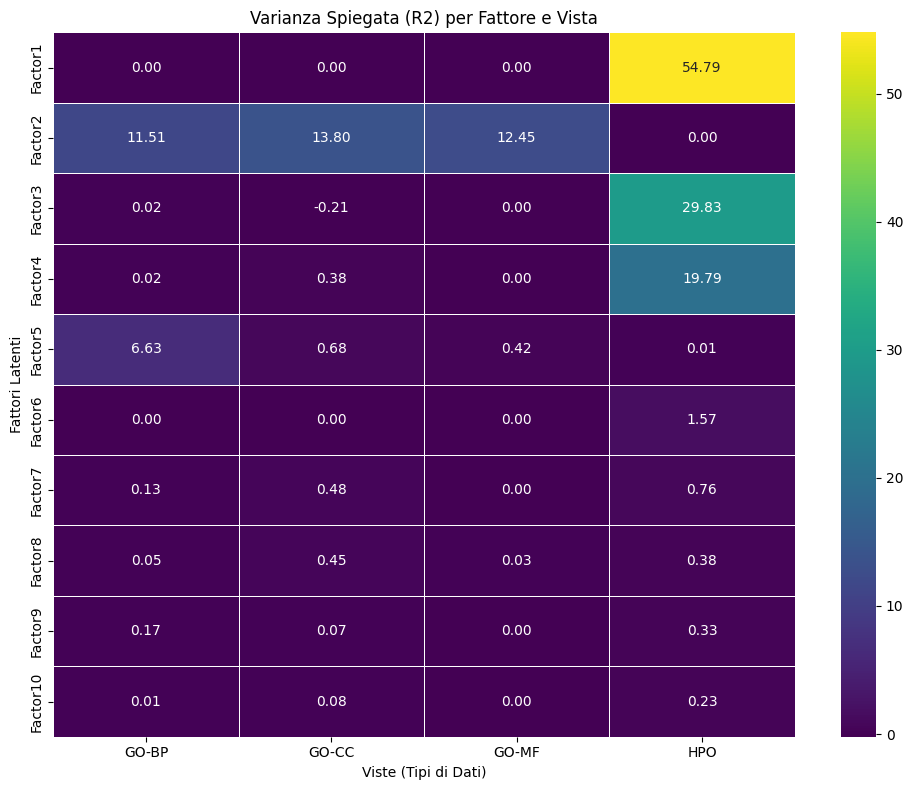

In [9]:
import mofax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- A. Carica il modello (se non è già caricato) ---
model = mofax.mofa_model(MODEL_OUTPUT_FILE)

# --- B. Estrai i dati della varianza ---
# La documentazione dice che restituisce un DataFrame
r2_df = model.get_variance_explained()

# Controlliamo com'è fatto il dataframe (per sicurezza)
print("Prime righe del dataframe R2:")
print(r2_df.head())

# --- C. Prepara la matrice per la Heatmap ---
# Il dataframe è solitamente in formato "lungo". Dobbiamo renderlo "largo" (pivot).
# Le colonne tipiche sono 'View', 'Factor', 'R2' (o 'Variance').
# Se hai un solo gruppo, ignoriamo la colonna 'Group'.

# Nota: Adatta i nomi delle colonne ("Factor", "View", "R2") se stampando head() vedi nomi diversi
# In mofax solitamente sono indici, quindi facciamo un pivot sicuro:
r2_matrix = r2_df.pivot(index='Factor', columns='View', values='R2')

# Ordiniamo i fattori (Factor1, Factor2, ...) per averli in ordine nel grafico
# Creiamo una lista ordinata
sorted_index = sorted(r2_matrix.index, key=lambda x: int(x.replace("Factor", "")))
r2_matrix = r2_matrix.reindex(sorted_index)

# --- D. Disegna la Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    r2_matrix, 
    cmap="viridis",   # Colori: dal blu scuro (poco) al giallo (tanto)
    annot=True,       # Scrive i numeri dentro le celle
    fmt=".2f",        # 2 cifre decimali
    linewidths=.5
)

plt.title("Varianza Spiegata (R2) per Fattore e Vista")
plt.ylabel("Fattori Latenti")
plt.xlabel("Viste (Tipi di Dati)")
plt.tight_layout()
plt.show()